In [1]:
import numpy as np
from scipy.special import erfcinv
from scipy.signal import max_len_seq
import scipy.signal as sg
import matplotlib.pyplot as plt

def generate_mls(m):
    """
    Generates a Maximal-Length Sequence (MLS) of {-1, 1}.
    
    Args:
        m (int): The number of bits in the shift register.
                 The sequence length will be L = 2^m - 1.
                 
    Returns:
        np.ndarray: The MLS sequence.
    """
    # The scipy function generates {0, 1}, which we map to {-1, 1}
    mls_01 = max_len_seq(m)[0]
    return (mls_01 * 2 - 1).astype(float)

def circular_correlate(in1, in2, mode='full'):
    """
    Computes the circular cross-correlation of two 1-dimensional sequences.
    
    This function uses the FFT method to compute the circular correlation, which is
    the correct method for analyzing periodic sequences like m-sequences.
    
    Args:
        in1 (array_like): The first input sequence.
        in2 (array_like): The second input sequence.
        mode (str, optional): Only 'full' mode is implemented, which returns
                              the correlation at all lags. Defaults to 'full'.

    Returns:
        np.ndarray: The circular cross-correlation of the sequences.
    """
    if mode != 'full':
        raise ValueError("Only 'full' mode is supported for circular_correlate.")
    
    # Use the FFT method for circular correlation.
    # The signals must be padded to the same length for the FFT.
    # The required length for a 'full' correlation is len(in1) + len(in2) - 1.
    out_len = len(in1) + len(in2) - 1
    
    # Compute the FFT of the first signal, padded to the output length
    fr1 = np.fft.fft(in1, n=out_len)
    
    # Compute the FFT of the second signal (flipped for correlation), padded
    fr2 = np.fft.fft(in2, n=out_len)
    
    # Perform element-wise multiplication of the FFTs (conjugate of the second)
    # This is the frequency-domain equivalent of time-domain correlation
    f_corr = fr1 * np.conj(fr2)
    
    # Compute the inverse FFT to get the time-domain correlation result
    corr = np.fft.ifft(f_corr)
    
    # The result of the IFFT is naturally periodic. We need to shift the
    # result to align the lags correctly, matching the output of np.correlate.
    # The zero-lag is at index 0, positive lags follow, and negative lags
    # are wrapped around at the end. fftshift moves the negative lags
    # to the beginning of the array.
    shifted_corr = np.fft.fftshift(corr)
    
    # Due to floating point inaccuracies, the result might be complex.
    # For real inputs, the result should be real.
    return np.real(shifted_corr)

def circular_correlate(in1, in2):
    """
    Computes the circular cross-correlation of two 1-dimensional sequences.
    
    This function uses the FFT method to compute the circular correlation, which is
    the correct method for analyzing periodic sequences like m-sequences.
    It assumes both input sequences have the same length.
    
    Args:
        in1 (array_like): The first input sequence.
        in2 (array_like): The second input sequence.

    Returns:
        np.ndarray: The circular cross-correlation of the sequences. The result
                    will have the same length as the inputs. Lag 0 is at index 0.
    """
    if len(in1) != len(in2):
        raise ValueError("Input sequences must have the same length for circular correlation.")
        
    # For true circular correlation, the FFT length is the signal length.
    L = len(in1)
    
    # Compute the FFTs of the input signals
    fr1 = np.fft.fft(in1)
    fr2 = np.fft.fft(in2)
    
    # Perform element-wise multiplication of the FFTs (conjugate of the second)
    f_corr = fr1 * np.conj(fr2)
    
    # Compute the inverse FFT to get the time-domain correlation result
    corr = np.fft.ifft(f_corr)
    
    # For real inputs, the result should be real.
    # The output is already in the correct circular order (lag 0 at index 0).
    return np.real(corr)


# PARAMETERS

In [2]:
# --- 1. Simulation Parameters ---
M_BITS = 11  # Number of bits for the PRBS generator
N_SAMPLES = 2**M_BITS - 1  # Sequence length is 2047

ECHO_DELAY = 250
MPI_DB = -30

ECHO_AMP = 10**(MPI_DB*0.05)         # The theoretical ratio we expect to converge to

# --- Target and System Parameters ---
target_ber = 1e-6  # Set your desired Bit Error Rate
# Assume BPSK modulation where signal power is normalized to 1.
signal_power_S = 1.0

# --- 1. Invert the BER formula to find the required Eb/N0 ---

# The inverse Q-function can be calculated using the inverse complementary error function:
# Q_inv(y) = sqrt(2) * erfcinv(2 * y)
q_inv_val = np.sqrt(2) * erfcinv(2 * target_ber)

# From the BPSK BER formula, we solve for the linear Eb/N0 ratio:
eb_n0_linear = 0.5 * q_inv_val**2
eb_n0_db = 10 * np.log10(eb_n0_linear)

# --- 2. Calculate the Noise Variance and Standard Deviation ---

# For BPSK, SNR is equivalent to Eb/N0.
# Since SNR = Signal_Power / Noise_Power and we assume Signal_Power = 1,
# Noise_Power (Variance) = 1 / SNR.
noise_variance = signal_power_S / eb_n0_linear
noise_sigma = np.sqrt(noise_variance)
NOISE_AMP = noise_sigma


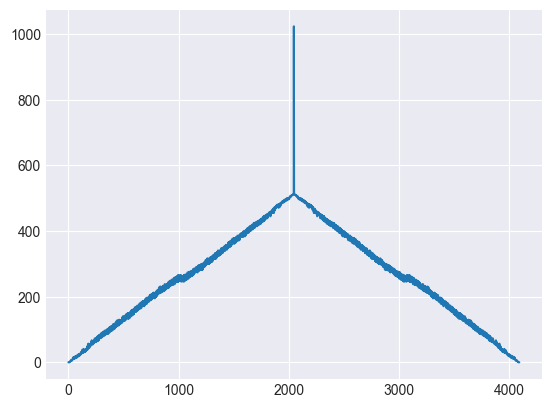

# Correlation between Tx and Rx, NOT removing the signal

Running sweep over number of averages...
Sweep complete. Plotting results.


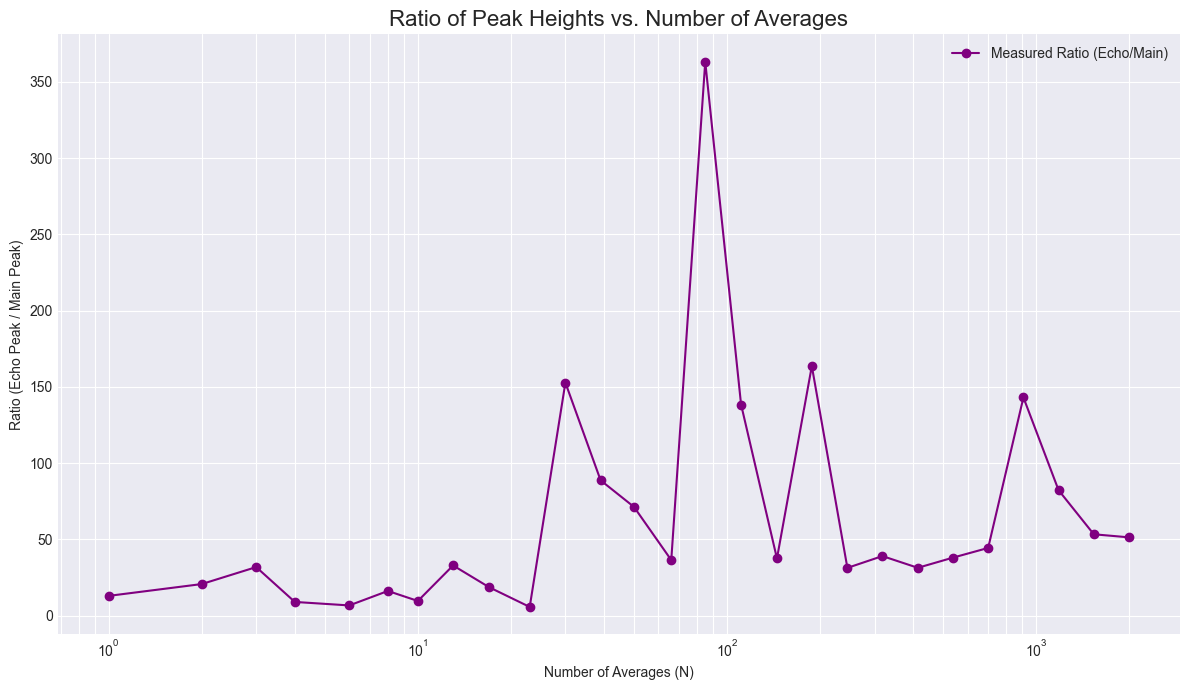

In [3]:
# Create a list of N values to sweep through, from 1 to 2000
n_avg_list = np.unique(np.logspace(0, 3.3, 30, dtype=int))

# List to store the results of our measurement
measured_ratios = []

# --- 2. Generate Base Transmitted Signal ---
tx_signal = generate_mls(M_BITS)
# --- 3. Run the Sweep ---
print("Running sweep over number of averages...")
for n_avg in n_avg_list:
    # Initialize an accumulator for the correlation
    corr_accumulator = np.zeros(N_SAMPLES)
    
    # Run the inner loop to perform the averaging
    for _ in range(n_avg):
        # Create the signal with echo
        clean_rx_signal = np.zeros(N_SAMPLES)
        clean_rx_signal += tx_signal # Direct path
        clean_rx_signal[ECHO_DELAY:] += tx_signal[:-ECHO_DELAY] * ECHO_AMP # Echo path
        
        # Add a new instance of random noise for this capture
        noise = np.random.randn(N_SAMPLES) * NOISE_AMP
        noisy_rx_signal = clean_rx_signal + noise
        
        # Correlate and add to the accumulator
        #corr = sg.correlate(noisy_rx_signal, tx_signal, mode='full')
        corr = circular_correlate(noisy_rx_signal, tx_signal)
        corr_accumulator += corr
        
    # Calculate the final averaged correlation
    avg_corr = corr_accumulator / n_avg
    
    # --- 4. Measure the Peak Heights and Ratio ---
    # Index for main peak (lag=0) in 'full' mode is N-1
    main_peak_idx = N_SAMPLES - 1
    main_peak_height = np.abs(avg_corr[main_peak_idx])
    
    # Index for echo peak (lag=ECHO_DELAY)
    echo_peak_idx = ECHO_DELAY
    echo_peak_height = np.abs(avg_corr[echo_peak_idx])
    
    # Calculate the ratio and store it
    ratio = echo_peak_height / main_peak_height
    measured_ratios.append(ratio)

print("Sweep complete. Plotting results.")
# --- 5. Plot the Final Result ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the measured ratio vs. the number of averages
ax.plot(n_avg_list, np.array(measured_ratios), 'o-', color='purple', label='Measured Ratio (Echo/Main)')

# Plot the theoretical ratio for comparison
# ax.axhline(y=ECHO_AMP, color='red', linestyle='--', lw=2, 
           # label=f'Theoretical Ratio (ECHO_AMP = {ECHO_AMP})')

ax.set_title('Ratio of Peak Heights vs. Number of Averages', fontsize=16)
ax.set_xlabel('Number of Averages (N)')
ax.set_ylabel('Ratio (Echo Peak / Main Peak)')
ax.set_xscale('log') # Log scale on X-axis is best for viewing the convergence
ax.grid(True, which="both")
ax.legend()
# Set y-axis limits around the theoretical value for a clearer view
# ax.set_ylim(ECHO_AMP * 0.8, ECHO_AMP * 1.2)
# 
plt.tight_layout()
plt.show()

## Correlating after removing the signal from the rx signal
It is not possible to see the main peak to side peak ratio (no signal anymore)
We can however compare the peak to the noise floor and call this "detectability".

Running sweep over number of averages...
Sweep complete. Plotting results.


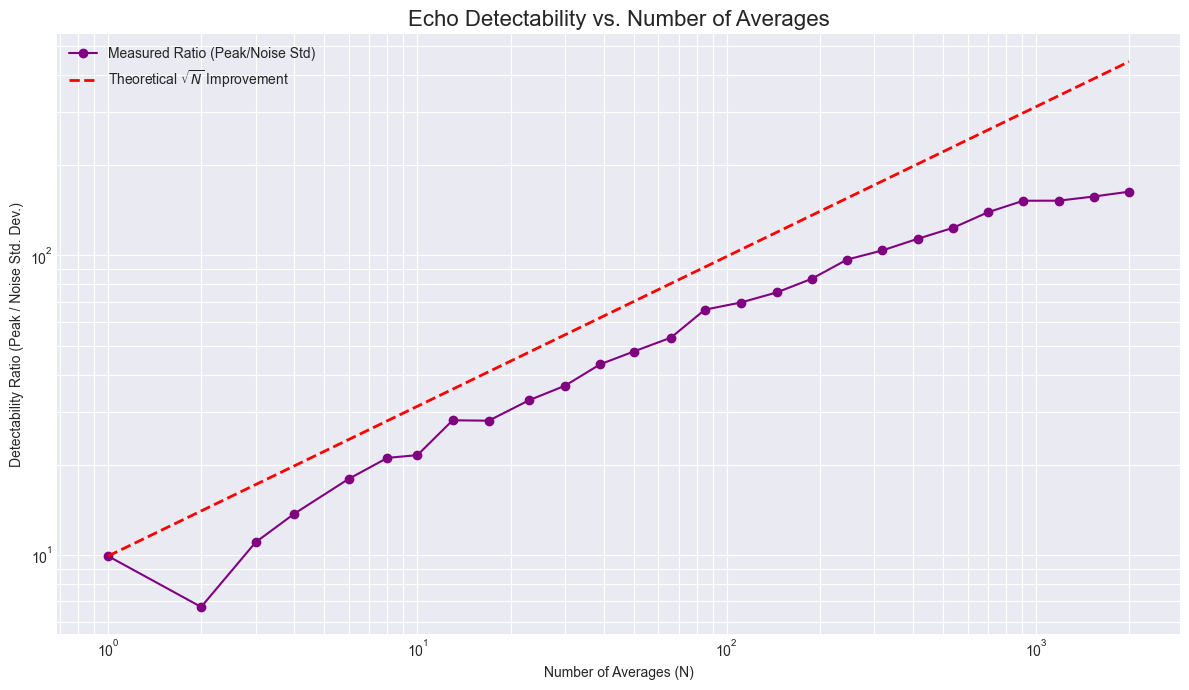

In [5]:
# --- 3. Run the Sweep ---
measured_ratios = []
print("Running sweep over number of averages...")
for n_avg in n_avg_list:
    # Initialize an accumulator for the correlation
    corr_accumulator = np.zeros(N_SAMPLES, dtype=float)
    
    # Run the inner loop to perform the averaging
    for _ in range(n_avg):
        # Create the signal with echo
        clean_rx_signal = np.zeros(N_SAMPLES)
        clean_rx_signal += tx_signal # Direct path
        clean_rx_signal[ECHO_DELAY:] += tx_signal[:-ECHO_DELAY] * ECHO_AMP # Echo path
        
        # Add a new instance of random noise for this capture
        noise = np.random.randn(N_SAMPLES) * NOISE_AMP
        noisy_rx_signal = clean_rx_signal + noise
        
        # Correlate and add to the accumulator
        # Using the subtraction method as in your provided code
        corr = circular_correlate(noisy_rx_signal - tx_signal, tx_signal)
        corr_accumulator += corr
        
    # Calculate the final averaged correlation
    avg_corr = corr_accumulator / n_avg
    
    # --- 4. Measure the Echo Peak and the Noise Floor ---
    # Index for echo peak (lag=ECHO_DELAY) in 'full' mode is lag + N - 1
    echo_peak_idx = ECHO_DELAY# + N_SAMPLES - 1
    echo_peak_height = np.abs(avg_corr[echo_peak_idx])
    
    # Define a region to measure the noise floor (away from the peaks)
    # This region should not contain the lag=0 or lag=ECHO_DELAY peaks.
    noise_region_start = ECHO_DELAY + 100
    noise_region_end = N_SAMPLES + 500
    noise_floor_samples = np.abs(avg_corr[noise_region_start:noise_region_end])
    noise_std = np.std(noise_floor_samples)
    
    # Calculate the ratio and store it, avoiding division by zero
    if noise_std > 0:
        ratio = echo_peak_height / noise_std
        measured_ratios.append(ratio)
    else:
        # Append a large number if noise is zero, though unlikely
        measured_ratios.append(np.inf)

print("Sweep complete. Plotting results.")

# --- 5. Plot the Final Result ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the measured ratio vs. the number of averages
ax.plot(n_avg_list, measured_ratios, 'o-', color='purple', label='Measured Ratio (Peak/Noise Std)')

# Plot the theoretical sqrt(N) improvement for comparison
# We scale the theoretical curve to match the first measured point
theory_improvement = measured_ratios[0] * np.sqrt(n_avg_list / n_avg_list[0])
ax.plot(n_avg_list, theory_improvement, '--', color='red', lw=2, 
        label=r'Theoretical $\sqrt{N}$ Improvement')

ax.set_title('Echo Detectability vs. Number of Averages', fontsize=16)
ax.set_xlabel('Number of Averages (N)')
ax.set_ylabel('Detectability Ratio (Peak / Noise Std. Dev.)')
ax.set_xscale('log')
ax.set_yscale('log') # Log-log scale shows the sqrt(N) trend as a straight line
ax.grid(True, which="both")
ax.legend()
plt.tight_layout()
plt.show()


## Introducing phase noise changes things

Running simulations...
Simulations complete. Plotting...
Running simulations...
Simulations complete. Plotting...


/var/folders/vs/hcw0dbrs611f1bymtf6vgdxm0000gn/T/ipykernel_99062/309564473.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/vs/hcw0dbrs611f1bymtf6vgdxm0000gn/T/ipykernel_99062/309564473.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


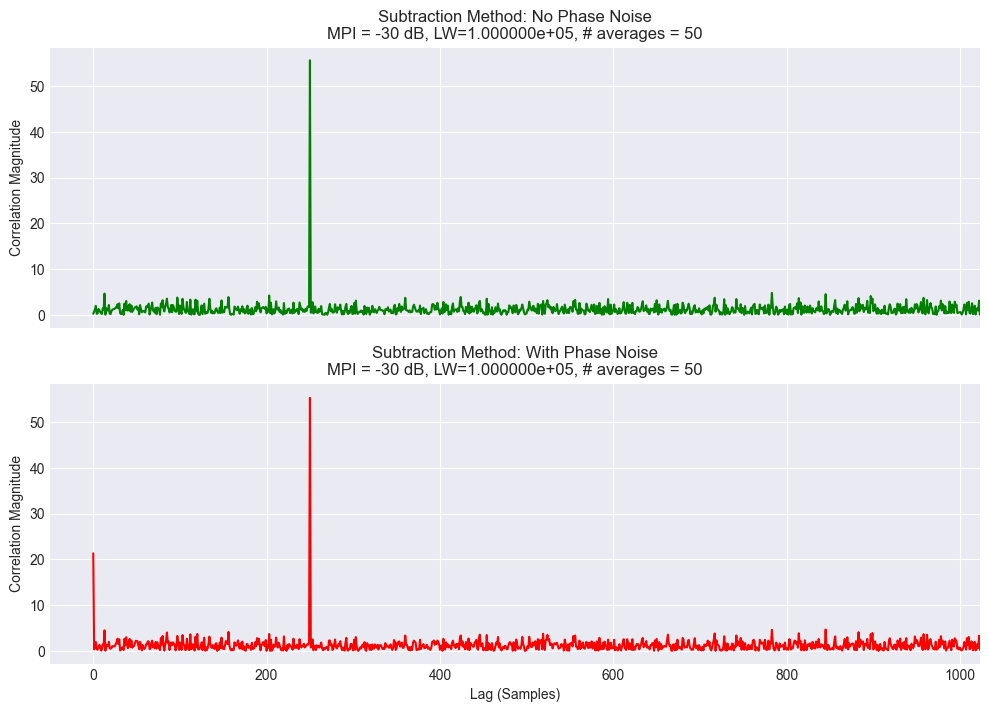

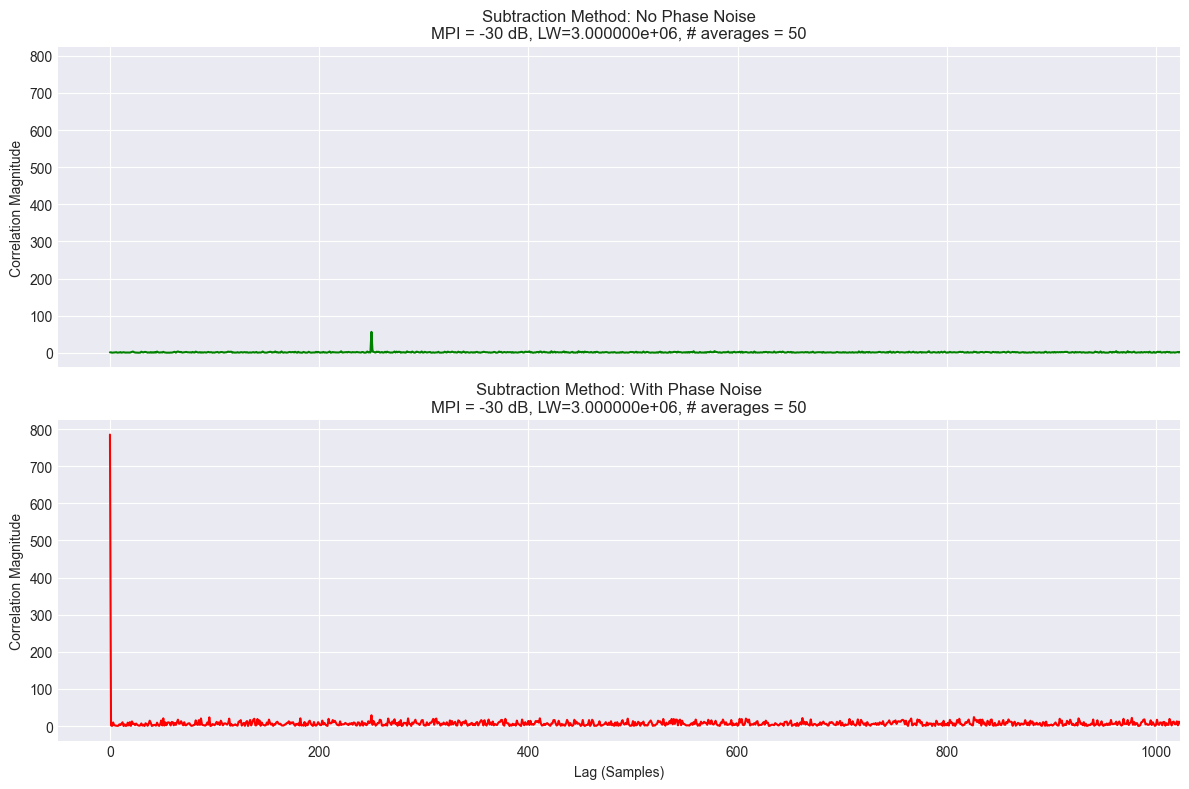

In [7]:
# Phase Noise Parameters
FS = 25e9                 # Sampling frequency
DELTA_F = [1e5, 3e6]            # Laser linewidth in Hz (moderate phase noise)
N_AVERAGES = 50

for f in DELTA_F:
    config = f'MPI = {MPI_DB:d} dB, LW={f:2e}, # averages = {N_AVERAGES}'
    # --- 3. Setup Accumulators and Noise Model ---
    corr_awgn_only = np.zeros(N_SAMPLES, dtype=np.complex128)
    corr_with_phase_noise = np.zeros(N_SAMPLES, dtype=np.complex128)
    
    phase_noise_variance = 2 * np.pi * f * (1/FS)
    sigma_w = np.sqrt(phase_noise_variance)
    
    # --- 4. Run Simulation for Both Cases ---
    print("Running simulations...")
    for _ in range(N_AVERAGES):
        # --- Generate the ideal received signal with echo ---
        rx_base = tx_signal.copy()
        rx_base[ECHO_DELAY:] += tx_signal[:-ECHO_DELAY] * ECHO_AMP
        
        # --- Add impairments ---
        awgn = (np.random.randn(N_SAMPLES) + 1j * np.random.randn(N_SAMPLES)) * NOISE_AMP / np.sqrt(2)
        phase_increments = np.random.randn(N_SAMPLES) * sigma_w
        phase_noise_process = np.cumsum(phase_increments)
    
        # Signal with only AWGN
        rx_with_awgn = rx_base + awgn
        
        # Signal with both AWGN and Phase Noise
        rx_with_all_noise = rx_with_awgn * np.exp(1j * phase_noise_process)
    
        # --- Correlate both cases using the subtraction method ---
        corr_awgn_only += circular_correlate(rx_with_awgn - tx_signal, tx_signal)
        corr_with_phase_noise += circular_correlate(rx_with_all_noise - tx_signal, tx_signal)
    
    # Finalize the averages
    avg_corr_awgn_only = corr_awgn_only / N_AVERAGES
    avg_corr_with_phase_noise = corr_with_phase_noise / N_AVERAGES

    print("Simulations complete. Plotting...")
    
    # --- 5. Plot the Comparison ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)
    lags = np.arange(0, N_SAMPLES)
    
    # Plot 1: AWGN Only Case
    ax1.plot(lags, np.abs(avg_corr_awgn_only), color='green')
    # ax1.axvline(ECHO_DELAY, color='c', linestyle='--', label=f'Echo Path ({ECHO_DELAY})')
    ax1.set_title(f'Subtraction Method: No Phase Noise\n{config}')
    ax1.set_ylabel('Correlation Magnitude')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: AWGN + Phase Noise Case
    ax2.plot(lags, np.abs(avg_corr_with_phase_noise), color='red')
    # ax2.axvline(ECHO_DELAY, color='c', linestyle='--', label=f'Echo Path ({ECHO_DELAY})')
    # ax2.axvline(0, color='orange', linestyle=':', label='Lag 0')
    ax2.set_title(f'Subtraction Method: With Phase Noise\n{config}')
    ax2.set_xlabel('Lag (Samples)')
    ax2.set_ylabel('Correlation Magnitude')
    ax2.legend()
    ax2.grid(True)
    
    ax1.set_xlim(-50, N_SAMPLES // 2)
plt.tight_layout()
plt.show()

--- Processing Linewidth: 1e+05 Hz ---


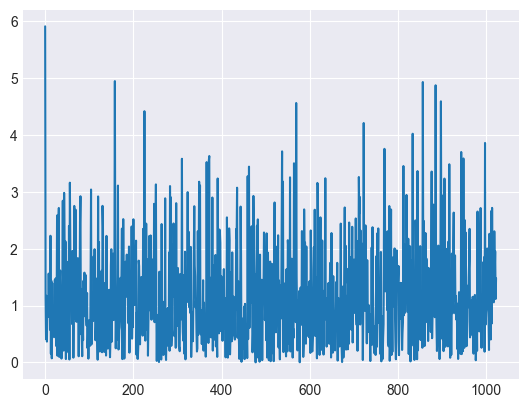

--- Processing Linewidth: 3e+06 Hz ---


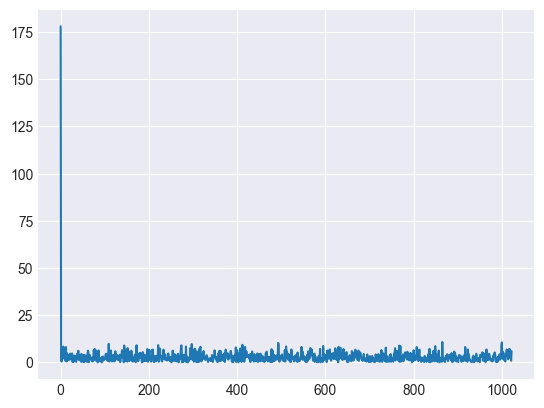

Simulations complete. Plotting results.


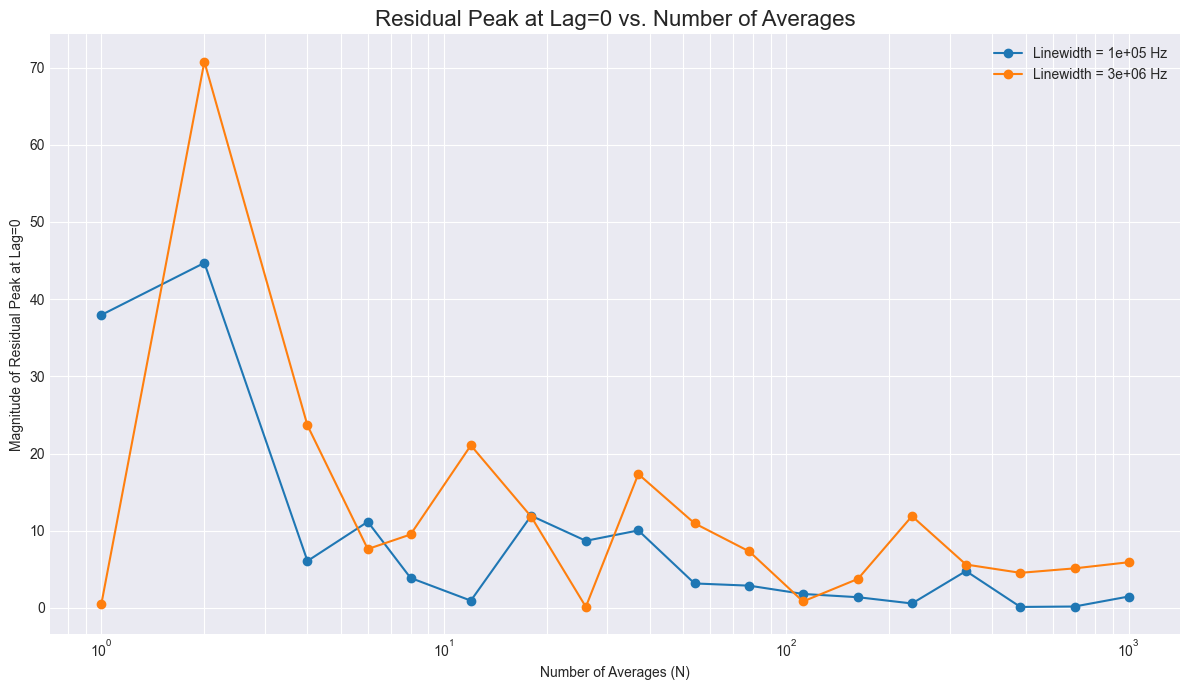

In [25]:

# List of linewidths and averages to sweep through
DELTA_F_list = [1e5, 3e6]  # [Low phase noise, High phase noise]
n_avg_list = np.unique(np.logspace(0, 3, 20, dtype=int)) # From 1 to 1000

# Dictionary to store the results for each linewidth
results = {}

# --- 3. Outer loop for Linewidth ---
for f in DELTA_F_list:
    print(f"--- Processing Linewidth: {f:.0e} Hz ---")
    
    # List to store measurements for the current linewidth
    measured_residual_peaks = []
    measured_echo_peaks = []
    # Calculate phase noise model parameter for this linewidth
    phase_noise_variance = 2 * np.pi * f * (1/FS)
    sigma_w = np.sqrt(phase_noise_variance)

    # --- Inner loop for Number of Averages ---
    for n_avg in n_avg_list:
        
        corr_accumulator = np.zeros(N_SAMPLES, dtype=np.complex128)
        
        # --- Innermost loop to perform averaging ---
        for _ in range(n_avg):
            # Generate the noisy received signal
            rx_base = tx_signal.copy()
            rx_base[ECHO_DELAY:] += tx_signal[:-ECHO_DELAY] * ECHO_AMP
            awgn = (np.random.randn(N_SAMPLES) + 1j * np.random.randn(N_SAMPLES)) * NOISE_AMP / np.sqrt(2)
            phase_increments = np.random.randn(N_SAMPLES) * sigma_w
            phase_noise_process = np.cumsum(phase_increments)
            
            rx_with_all_noise = (rx_base + awgn) * np.exp(1j * phase_noise_process)

            # Correlate using the full-signal subtraction method
            corr = circular_correlate(rx_with_all_noise - tx_signal, tx_signal)
            corr_accumulator += corr

        # Finalize the average for this N
        avg_corr = corr_accumulator / n_avg
        
        # --- Measure the residual peak at lag=0 ---
        residual_peak_height = np.abs(avg_corr[N_SAMPLES - 1])
        measured_residual_peaks.append(residual_peak_height)
        measured_echo_peaks.append(np.abs(avg_corr[ECHO_DELAY]))
                                   
    # Store the list of results for this linewidth
    results[f] = measured_residual_peaks
    plt.figure()
    plt.plot(np.abs(avg_corr))
    plt.show()

print("Simulations complete. Plotting results.")

# --- 4. Plot the Final Result ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the results for each linewidth
for f, peak_heights in results.items():
    ax.plot(n_avg_list, peak_heights, 'o-', label=f'Linewidth = {f:.0e} Hz')

ax.set_title('Residual Peak at Lag=0 vs. Number of Averages', fontsize=16)
ax.set_xlabel('Number of Averages (N)')
ax.set_ylabel('Magnitude of Residual Peak at Lag=0')
ax.set_xscale('log')
ax.grid(True, which="both")
ax.legend()

plt.tight_layout()
plt.show()

Running simulation with short-block correlation...
Simulation complete. Plotting...


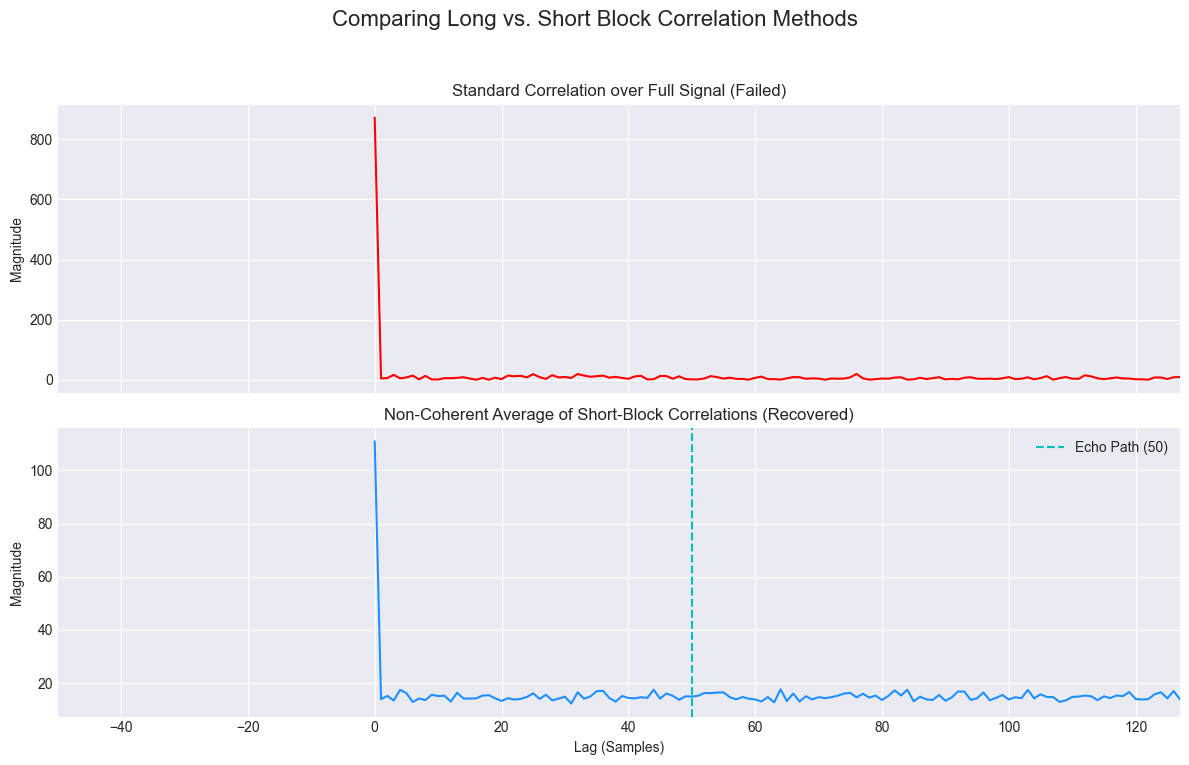

In [23]:
BLOCK_SIZE = 128         # Key parameter: size of short blocks for correlation
N_BLOCKS = N_SAMPLES // BLOCK_SIZE

short_corr_accumulator = np.zeros(BLOCK_SIZE)
# Accumulator for the standard "long block" method for comparison
long_corr_accumulator = np.zeros(N_SAMPLES, dtype=np.complex128)

# --- 4. Run Simulation ---

print("Running simulation with short-block correlation...")
# Calculate phase noise model parameter
DELTA_F = 3e6

phase_noise_variance = 2 * np.pi * DELTA_F * (1/FS)
sigma_w = np.sqrt(phase_noise_variance)
for i in range(N_AVERAGES):
    # Generate the full noisy received signal for this capture
    rx_base = tx_signal.copy()
    rx_base[ECHO_DELAY:] += tx_signal[:-ECHO_DELAY] * ECHO_AMP
    awgn = (np.random.randn(N_SAMPLES) + 1j * np.random.randn(N_SAMPLES)) * NOISE_AMP / np.sqrt(2)
    phase_increments = np.random.randn(N_SAMPLES) * sigma_w
    phase_noise_process = np.cumsum(phase_increments)
    rx_with_all_noise = (rx_base + awgn) * np.exp(1j * phase_noise_process)

    # --- Method A: Standard Long Block Correlation (Expected to Fail) ---
    # We use the simple corr(Rx, Tx) as the subtraction method also fails
    long_corr_accumulator += circular_correlate(rx_with_all_noise, tx_signal)

    # --- Method B: Non-Coherent Short Block Averaging ---
    for k in range(N_BLOCKS):
        start_idx = k * BLOCK_SIZE
        end_idx = start_idx + BLOCK_SIZE
        
        rx_block = rx_with_all_noise[start_idx:end_idx]
        tx_block = tx_signal[start_idx:end_idx]
        
        # Correlate this short block using standard linear correlation
        short_corr = circular_correlate(rx_block, tx_block)
        
        # Add the magnitude of the correlation curve to the accumulator
        short_corr_accumulator += np.abs(short_corr)

# Finalize averages
avg_long_corr = long_corr_accumulator / N_AVERAGES
avg_short_corr = short_corr_accumulator / (N_AVERAGES * N_BLOCKS)

print("Simulation complete. Plotting...")

# --- 5. Plot Comparison ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Comparing Long vs. Short Block Correlation Methods', fontsize=16)

# Plot 1: Standard Correlation (Failed)
long_lags = np.arange(0,N_SAMPLES)
ax1.plot(long_lags, np.abs(avg_long_corr), color='red')
ax1.set_title('Standard Correlation over Full Signal (Failed)')
ax1.set_ylabel('Magnitude')
ax1.grid(True)

# Plot 2: Short-Block Correlation (Recovered)
short_lags = np.arange(0, BLOCK_SIZE)
ax2.plot(short_lags, avg_short_corr, color='dodgerblue')
ax2.axvline(ECHO_DELAY, color='c', linestyle='--', label=f'Echo Path ({ECHO_DELAY})')
ax2.set_title('Non-Coherent Average of Short-Block Correlations (Recovered)')
ax2.set_xlabel('Lag (Samples)')
ax2.set_ylabel('Magnitude')
ax2.legend()
ax2.grid(True)

# Set x-limits to zoom in on the relevant area
ax2.set_xlim(-50, BLOCK_SIZE - 1)
peak_height = avg_short_corr[ECHO_DELAY]# + BLOCK_SIZE - 1]
# ax2.set_ylim(0, peak_height * 1.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

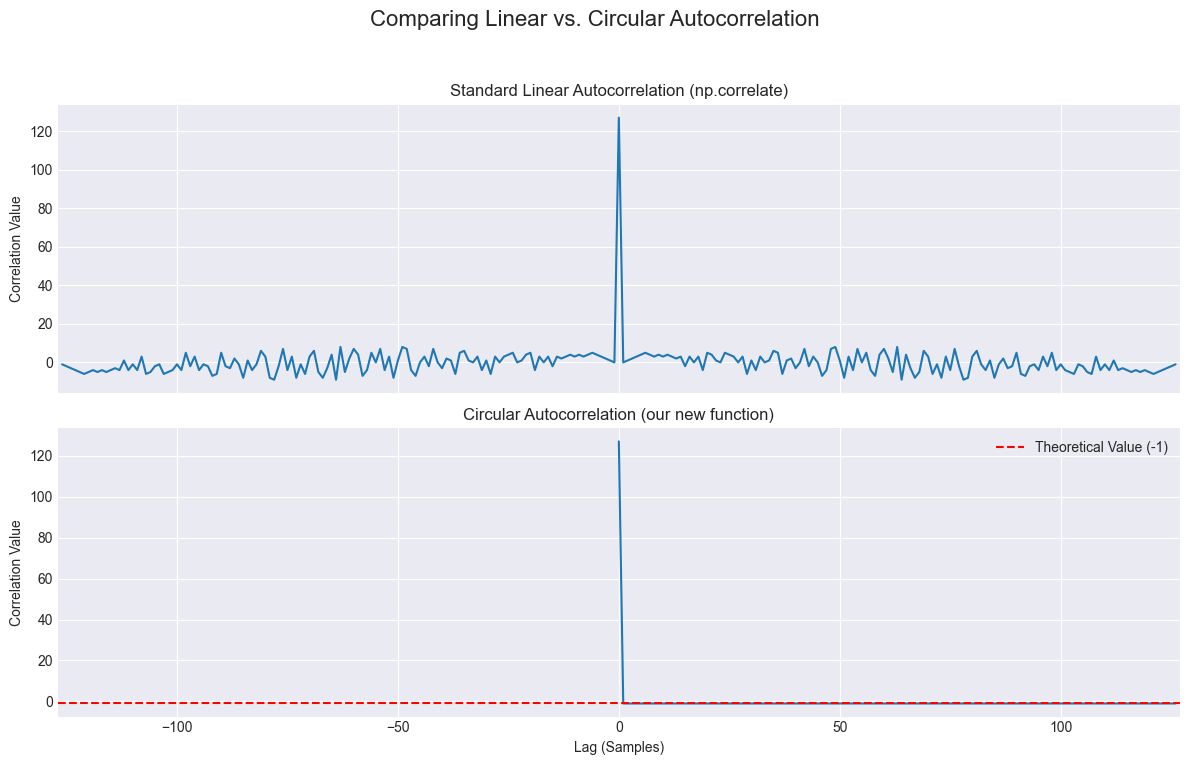

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import max_len_seq

def circular_correlate(in1, in2, mode='full'):
    """
    Computes the circular cross-correlation of two 1-dimensional sequences.
    
    This function uses the FFT method to compute the circular correlation, which is
    the correct method for analyzing periodic sequences like m-sequences.
    
    Args:
        in1 (array_like): The first input sequence.
        in2 (array_like): The second input sequence.
        mode (str, optional): Only 'full' mode is implemented, which returns
                              the correlation at all lags. Defaults to 'full'.

    Returns:
        np.ndarray: The circular cross-correlation of the sequences.
    """
    if mode != 'full':
        raise ValueError("Only 'full' mode is supported for circular_correlate.")
    
    # Use the FFT method for circular correlation.
    # The signals must be padded to the same length for the FFT.
    # The required length for a 'full' correlation is len(in1) + len(in2) - 1.
    out_len = len(in1) + len(in2) - 1
    
    # Compute the FFT of the first signal, padded to the output length
    fr1 = np.fft.fft(in1, n=out_len)
    
    # Compute the FFT of the second signal (flipped for correlation), padded
    fr2 = np.fft.fft(in2, n=out_len)
    
    # Perform element-wise multiplication of the FFTs (conjugate of the second)
    # This is the frequency-domain equivalent of time-domain correlation
    f_corr = fr1 * np.conj(fr2)
    
    # Compute the inverse FFT to get the time-domain correlation result
    corr = np.fft.ifft(f_corr)
    
    # The result of the IFFT is naturally periodic. We need to shift the
    # result to align the lags correctly, matching the output of np.correlate.
    # The zero-lag is at index 0, positive lags follow, and negative lags
    # are wrapped around at the end. fftshift moves the negative lags
    # to the beginning of the array.
    shifted_corr = np.fft.fftshift(corr)
    
    # Due to floating point inaccuracies, the result might be complex.
    # For real inputs, the result should be real.
    return np.real(shifted_corr)

def circular_correlate(in1, in2):
    """
    Computes the circular cross-correlation of two 1-dimensional sequences.
    
    This function uses the FFT method to compute the circular correlation, which is
    the correct method for analyzing periodic sequences like m-sequences.
    It assumes both input sequences have the same length.
    
    Args:
        in1 (array_like): The first input sequence.
        in2 (array_like): The second input sequence.

    Returns:
        np.ndarray: The circular cross-correlation of the sequences. The result
                    will have the same length as the inputs. Lag 0 is at index 0.
    """
    if len(in1) != len(in2):
        raise ValueError("Input sequences must have the same length for circular correlation.")
        
    # For true circular correlation, the FFT length is the signal length.
    L = len(in1)
    
    # Compute the FFTs of the input signals
    fr1 = np.fft.fft(in1)
    fr2 = np.fft.fft(in2)
    
    # Perform element-wise multiplication of the FFTs (conjugate of the second)
    f_corr = fr1 * np.conj(fr2)
    
    # Compute the inverse FFT to get the time-domain correlation result
    corr = np.fft.ifft(f_corr)
    
    # For real inputs, the result should be real.
    # The output is already in the correct circular order (lag 0 at index 0).
    return np.real(corr)



# --- Demonstration of the function ---

# 1. Generate an m-sequence
m_bits = 7
L = 2**m_bits - 1
m_seq = (max_len_seq(m_bits)[0] * 2 - 1).astype(float)

# 2. Perform both linear and circular autocorrelation
linear_corr = np.correlate(m_seq, m_seq, mode='full')
circ_corr = circular_correlate(m_seq, m_seq)

# 3. Plot for comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Comparing Linear vs. Circular Autocorrelation', fontsize=16)
lags = np.arange(-L + 1, L)

# Plot Linear Autocorrelation (from NumPy)
ax1.plot(lags, linear_corr)
ax1.set_title('Standard Linear Autocorrelation (np.correlate)')
ax1.set_ylabel('Correlation Value')
ax1.grid(True)

# Plot Circular Autocorrelation (from our new function)
ax2.plot(circ_corr)
ax2.set_title('Circular Autocorrelation (our new function)')
ax2.set_xlabel('Lag (Samples)')
ax2.set_ylabel('Correlation Value')
ax2.grid(True)
# The theoretical value for non-zero lags is -1
ax2.axhline(-1, color='r', linestyle='--', label='Theoretical Value (-1)')
ax2.legend()

plt.xlim(-L, L)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
